# Plots

First, import some packages, set the plottingstyle, and define key variables. _Note_: I have a few custom plotting defaults that I use, so unless you update your `matplotlibrc` defaults to match those below, your figure aesthetics will be different!

```
$ cat ~/.config/matplotlib/matplotlibrc
lines.linewidth: 2
lines.markeredgecolor: k
lines.markeredgewidth: 1.3
boxplot.whiskers: 1.5
boxplot.patchartist: True
boxplot.showmeans: True
boxplot.meanline: False
boxplot.boxprops.facecolor: None
boxplot.boxprops.linewidth: 1.5
boxplot.whiskerprops.linewidth: 1.5
boxplot.medianprops.linewidth: 1.5
boxplot.medianprops.color: None
boxplot.meanprops.marker: ^
boxplot.meanprops.markerfacecolor: w
boxplot.meanprops.markeredgecolor: k
axes.grid: True
grid.linestyle: --
savefig.bbox: tight
```

In [1]:
from pathlib import Path
from typing import Iterable, Union

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import trapezoid
import seaborn as sns

rc = mpl.rc_params_from_file(mpl.matplotlib_fname(), use_default_template=False)
sns.set_theme(style="white", rc=rc)

ROGI_KEY = "rogi"
CSV_DIR = Path("./results/raw/rogi/tdc")
FEATURES = ["VAE", "GIN", "ChemBERTa", "ChemGPT"]
FEATURES_TO_COLOR = {
    f.upper(): c for f, c in zip(FEATURES, sns.color_palette("deep", len(FEATURES)))
}

print("Loaded custom defaults: ")
for k, v in rc.items():
    print(f"  {k}: {v}")


Bad key boxplot.boxprops.facecolor in file /home/degraff/.config/matplotlib/matplotlibrc, line 15 ('boxplot.boxprops.facecolor: None')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.6.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key boxplot.boxprops.facecolor in file /home/degraff/.config/matplotlib/matplotlibrc, line 15 ('boxplot.boxprops.facecolor: None')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.6.3/matplotlibrc.template
or from the matplotlib source distribution


Loaded custom defaults: 
  axes.grid: True
  boxplot.boxprops.linewidth: 1.5
  boxplot.meanline: False
  boxplot.meanprops.marker: ^
  boxplot.meanprops.markeredgecolor: k
  boxplot.meanprops.markerfacecolor: w
  boxplot.medianprops.color: none
  boxplot.medianprops.linewidth: 1.5
  boxplot.patchartist: True
  boxplot.showmeans: True
  boxplot.whiskerprops.linewidth: 1.5
  boxplot.whiskers: 1.5
  grid.linestyle: --
  hist.bins: auto
  lines.linewidth: 2.0
  lines.markeredgecolor: k
  lines.markeredgewidth: 1.3
  savefig.bbox: tight


In [2]:
def disable_gridlines(ax: plt.Axes, axis: str, vals: Union[float, Iterable[float]]):
    if isinstance(vals, float):
        vals = [vals]

    vals = set(vals)
    gridlines = ax.get_xgridlines() if axis == "x" else ax.get_ygridlines()

    for line in gridlines:
        val = line.get_xdata()[0] if axis == "x" else line.get_ydata()[0]
        if val in vals:
            line.set_visible(False)
    
    return ax


def rogi_string(x: str):
    return rf"$\mathrm{{ROGI}}_{{\mathrm{{{x}}}}}$"

In [3]:
dfs = list(map(pd.read_csv, CSV_DIR.iterdir()))
df = pd.concat(dfs, ignore_index=True)\
    .groupby(["features", "dataset_and_task"])\
    .agg({"n_valid": "mean", "rogi": ["mean", "std", "count"]})\
    .sort_index()

df.head(15)

n_valid      rogi                
                                           mean      mean       std count
features  dataset_and_task                                               
chemberta ARIPIPRAZOLE_SIMILARITY       10000.0  0.224105  0.000000     5
          CACO2_WANG                      910.0  0.286850  0.000000     5
          CELECOXIB_REDISCOVERY         10000.0  0.244493  0.000000     5
          CLEARANCE_HEPATOCYTE_AZ        1213.0  0.569957  0.000000     5
          CLEARANCE_MICROSOME_AZ         1102.0  0.501762  0.000000     5
          HALF_LIFE_OBACH                 667.0  0.110947  0.000000     5
          HERG_CENTRAL/hERG_at_10uM     10000.0  0.151121  0.060735     5
          HERG_CENTRAL/hERG_at_1uM      10000.0  0.101376  0.033180     5
          HERG_CENTRAL/hERG_inhib       10000.0  0.370091  0.004480     5
          HYDRATIONFREEENERGY_FREESOLV    642.0  0.201576  0.000000     5
          LD50_ZHU                       7385.0  0.150139  0.000000     5
          LIPOPHILICITY_ASTRAZENECA      4200.0  0.341132  0.000000     5
          MEDIAN 1                      10000.0  0.208131  0.000000     5
          PPBR_AZ                        1614.0  0.310439  0.000000     5
          SCAFFOLD HOP                  10000.0  0.258352  0.000000     5

In [20]:
def parity_plot(
    ax: plt.Axes, df: pd.DataFrame, x_key: str, y_key: str, threshold: float = 0.1
):
    x = df.loc[x_key.lower()][ROGI_KEY]['mean']
    y = df.loc[y_key.lower()][ROGI_KEY]['mean']
    s = df.loc[x_key.lower()]["n_valid"]['mean'].values / 1e2
    z = (y - x) / x

    ax.scatter(x, y, s, z, vmin=-1, vmax=1, cmap="coolwarm", edgecolors='k', lw=1.3)
    ax.plot([[0, 0], [1, 1]], '--', c='grey', dashes=(4, 2.5), zorder=-1)

    roughest_dset = z.idxmax()
    i = z.index.get_loc(roughest_dset)
    # arrowprops = dict(arrowstyle="-|>,width=1", facecolor='black')
    arrowprops = dict(width=2.5, headwidth=10, shrink=0.2, facecolor='k')
    ax.annotate(
        roughest_dset,
        (x[i], y[i]),
        (0.225, 0.45),
        textcoords='data',
        ha="center",
        arrowprops=arrowprops,
        fontsize=10
    )

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    ax.set_title(y_key)

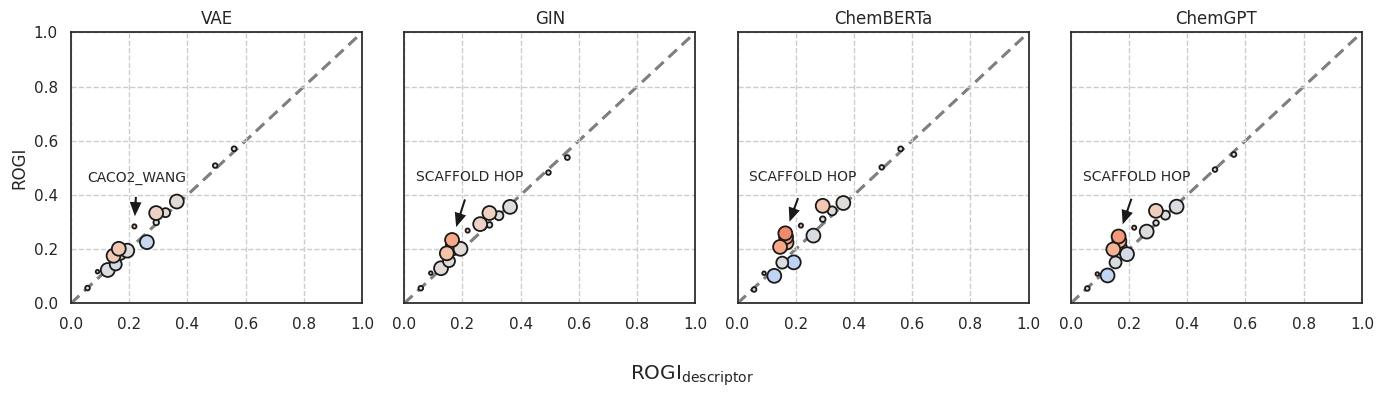

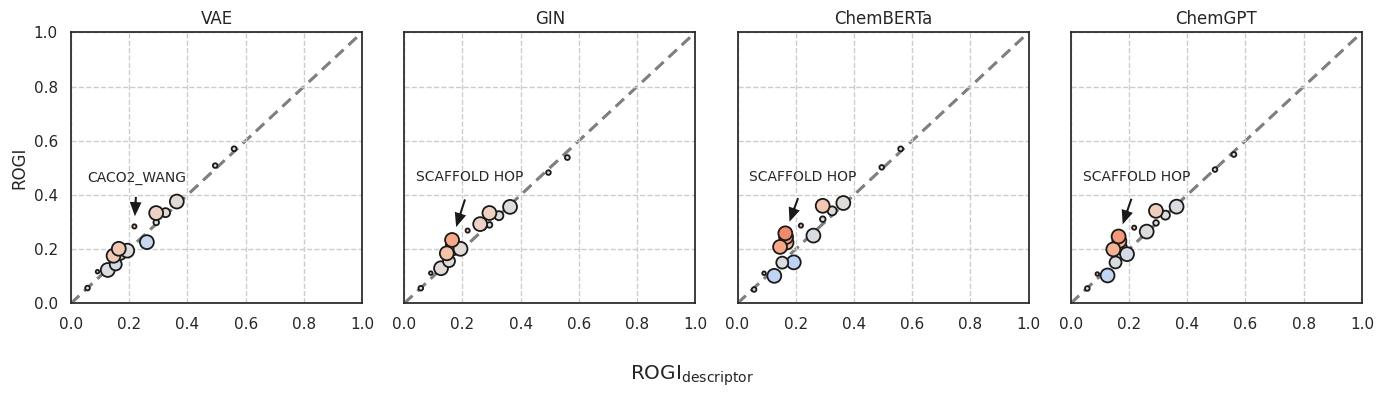

In [21]:
desc_key = "descriptor"
features = ["VAE", "GIN", "ChemBERTa", "ChemGPT"]
N = len(features)
fig, axs = plt.subplots(1, N, figsize=(3.5 * N, 4), sharex=True, sharey=True)

for i in range(len(features)):
    ax = axs[i]
    feature = features[i]
    parity_plot(ax, df, desc_key, feature, 0.10)
    if i == 0:
        ax.set_ylabel("ROGI")

fig.supxlabel(rogi_string(desc_key))
fig.tight_layout()

fig

In [22]:
fig.savefig(f"./results/figures/{'-'.join(features)}.pdf", bbox_inches="tight")

In [23]:
def boxplot(
    ax: plt.Axes,
    df: pd.DataFrame,
    desc_key: str,
    features: list[str],
    jitter: float = 0.05,
    add_counts: bool = False,
    threshold: float = 0.1,
):
    BUFFER = 3

    x = df.loc[desc_key.lower()][ROGI_KEY]['mean'].values
    ys = [df.loc[f.lower()][ROGI_KEY]['mean'].values for f in features]
    Z = np.array(ys) / x - 1
    Z *= 100

    ax.boxplot(
        Z.T,
        vert=False,
        labels=features,
        widths=0.5,
        showmeans=True,
        patch_artist=True,
        boxprops=dict(fc="None"),
        medianprops=dict(c=None)
    )

    ax.grid(which="both", axis="x", ls="--", dashes=(4, 4))

    for j in range(len(Z)):
        z = Z[j]
        y = (j + 1) + np.random.uniform(-jitter, jitter, z.shape)

        c = FEATURES_TO_COLOR[features[j].upper()]
        ax.plot(z, y, 'o', color=c)

        if add_counts:
            s = rf"$f\geq{threshold:0.0%}$% = {(z > threshold).sum()}/{len(z)}"
            ax.text(
                ax.get_xlim()[1] + BUFFER, j+1, s, fontsize=10,
                ha="left", va="center"
            )

    ax.set_xlabel(f"Relative difference betweeen {rogi_string('*')} and {rogi_string('desc')} (%)")
    ax.grid(False, axis='y')
    
    return ax

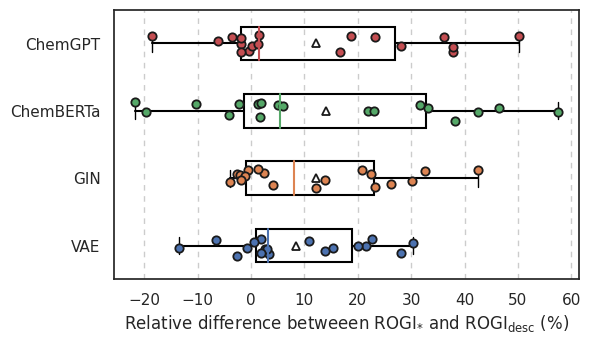

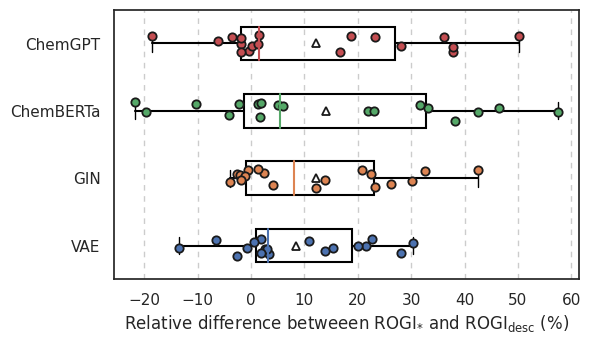

In [24]:
features = ["VAE", "GIN", "ChemBERTa", "ChemGPT"]
add_counts = False
fig, ax = plt.subplots(1, 1, figsize=(6 + add_counts, len(features) * 0.875))

boxplot(ax, df, "descriptor", features, 0.15)

fig

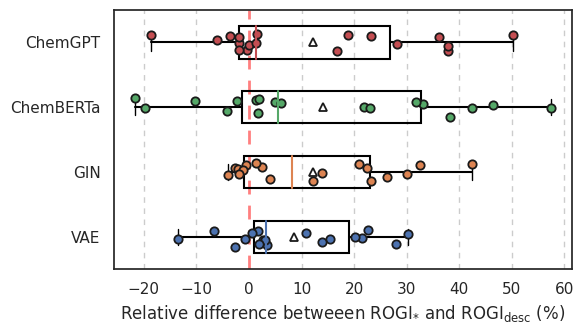

In [25]:
disable_gridlines(ax, "x", [0])
ax.axvline(0, ls="--", color="red", dashes=(5, 4), zorder=-10, alpha=0.5)

fig.tight_layout()
fig

In [26]:
fig.savefig("./results/figures/scatter-boxplot.pdf", bbox_inches="tight")

In [27]:
JSON_DIR = Path("./results/raw/cg/sample/")

jsons = JSON_DIR.iterdir()
dfs = list(map(pd.read_json, jsons))
cg_df = pd.concat(dfs, ignore_index=True).set_index(["dataset_and_task", "features"]).sort_index()

cg_df.head()

n_valid  \
dataset_and_task        features              
CLEARANCE_HEPATOCYTE_AZ chemberta      1213   
                        chemgpt        1213   
                        descriptor     1213   
                        gin            1213   
                        vae            1213   

                                                                           thresholds  \
dataset_and_task        features                                                        
CLEARANCE_HEPATOCYTE_AZ chemberta   [0.0, 0.0, 0.0103709124, 0.0204890079, 0.03065...   
                        chemgpt     [0.0, 0.0, 0.0119580906, 0.0271676201, 0.04248...   
                        descriptor  [0.0, 0.0, 0.0100729401, 0.0202109427, 0.03028...   
                        gin         [0.0, 1.1400000000000001e-08, 0.0132596028, 0....   
                        vae         [0.0, 0.020852984, 0.0308840157, 0.04088592200...   

                                                                                  sds  
dataset_and_task        features                                                       
CLEARANCE_HEPATOCYTE_AZ chemberta   [0.677915252, 0.6579093666, 0.6318523113, 0.62...  
                        chemgpt     [0.677915252, 0.6721596040000001, 0.6721259207...  
                        descriptor  [0.677915252, 0.6317526745, 0.6295295067000001...  
                        gin         [0.677915252, 0.6777421332, 0.6362961095, 0.63...  
                        vae         [0.677915252, 0.6778844101, 0.6581691495, 0.59...

In [28]:
def dispersion_plot(ax: plt.Axes, thresholds, sds, title = None, y_label = None):
    BUFFER = 0.03

    y = sds[0] - sds
    ax.plot(thresholds, y, '-')
    ax.fill_between(thresholds, 0, y, alpha=0.3)

    rogi = sds[0] - trapezoid(sds, thresholds)
    s = f"ROGI = {rogi:0.3f}"
    bbox = dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='none')
    ax.text(
        0 + BUFFER, 1 - BUFFER, s,
        ha="left", va="top", fontsize=10, transform=ax.transAxes, bbox=bbox
    )
    
    ax2 = ax.twinx()
    ax2.set_title(title, fontsize=12)
    ax2.set_ylabel(y_label, fontsize=10, labelpad=6, rotation=-90)
    ax2.yaxis.set_ticks([])#('none')

    ax.set_xlim(0, 1)
    ax.set_ylim(0)
    ax.yaxis.set_tick_params(which="both", direction="in", pad=6)
    ax.grid(False)

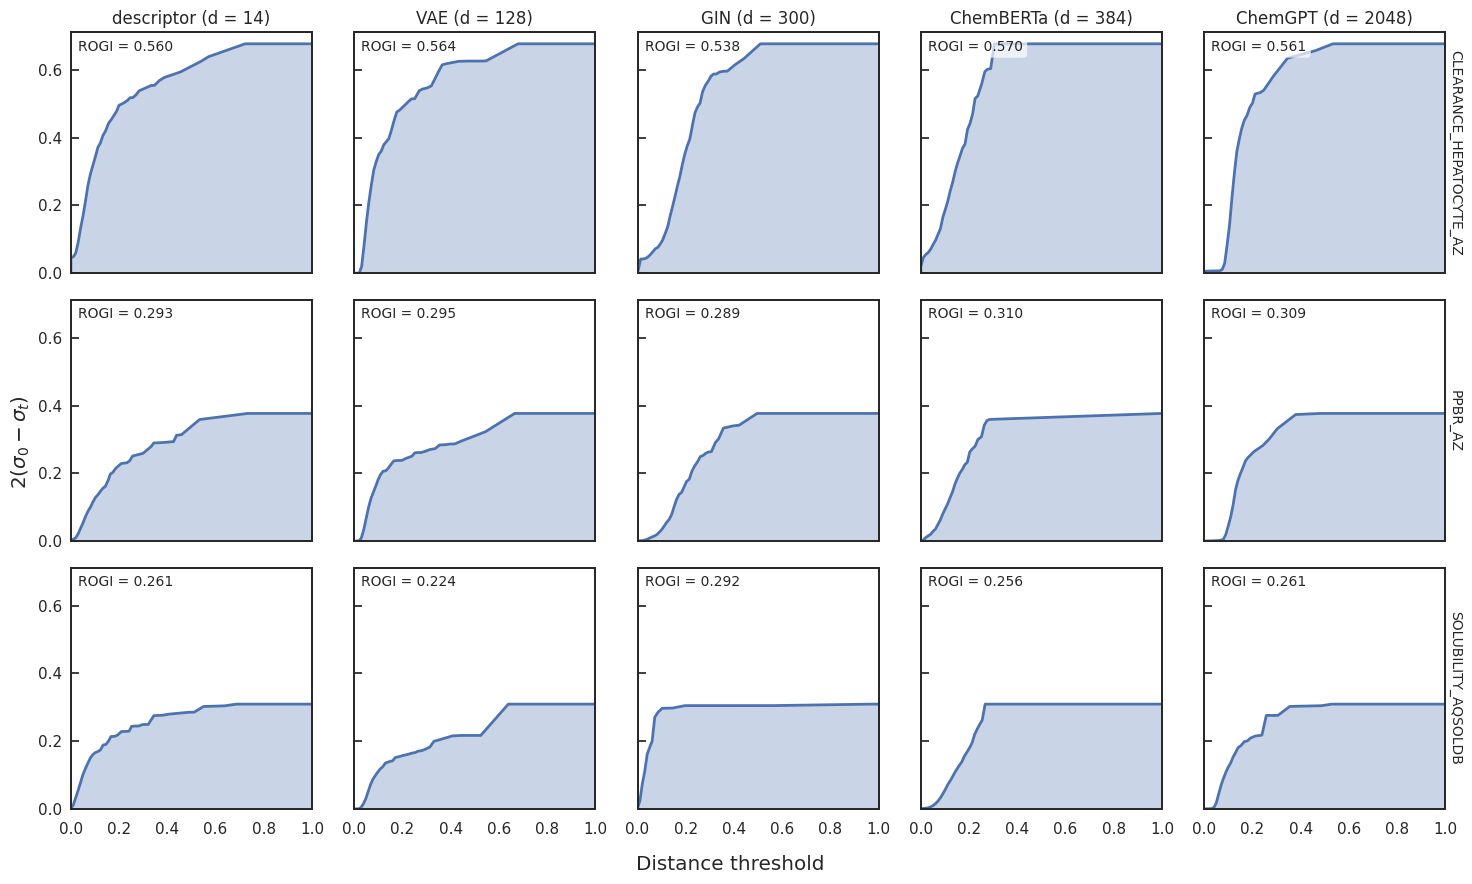

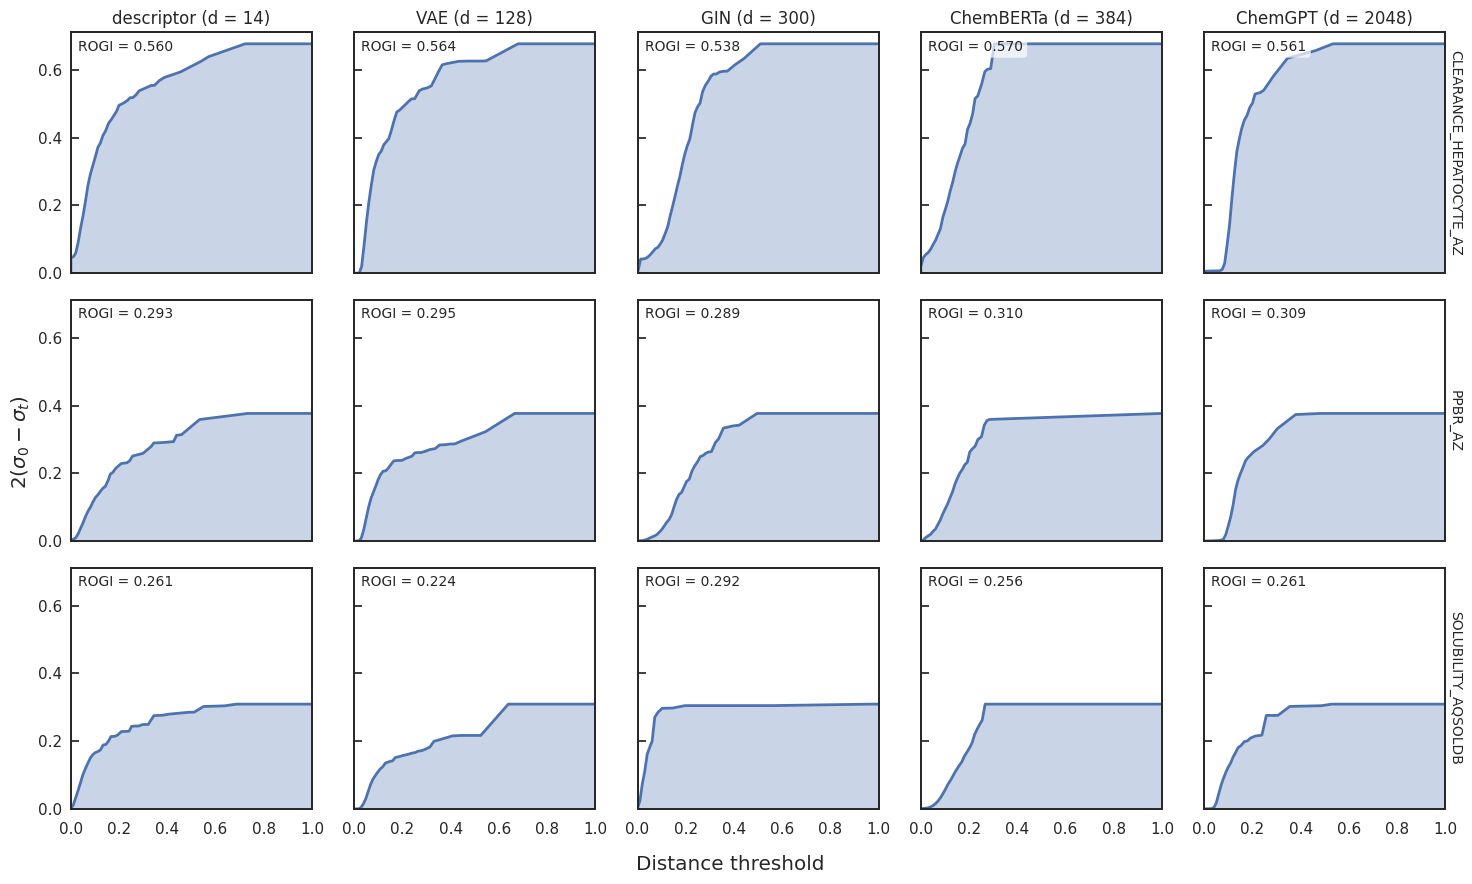

In [29]:
nrows, ncols = cg_df.index.levshape
fig, axs = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows), sharex=True, sharey=True)

features = ["descriptor", "VAE", "GIN", "ChemBERTa", "ChemGPT"]
dims = [14, 128, 300, 384, 2048]

for i, dset in enumerate(cg_df.index.get_level_values("dataset_and_task").unique()):
    for j, feature in enumerate(features):
        s = cg_df.loc[dset, feature.lower()]

        title = f"{feature} (d = {dims[j]})" if i == 0 else None
        y_label = dset if j == len(features) - 1 else None
        dispersion_plot(axs[i, j], s.thresholds, np.array(s.sds), title, y_label)

fig.subplots_adjust(wspace=1)
fig.supxlabel("Distance threshold", y=0.02)
fig.supylabel(r"$2(\sigma_0 - \sigma_t)$")
fig.tight_layout()

fig

In [30]:
fig.savefig("./results/figures/thresh-vs-sds.pdf", bbox_inches="tight")